Solve the period finding problem for **a = 7** and **N = 15**. The circuit for U is provided by us, U is given by: U|y⟩=|aymod15⟩

To create the circuit U<sup>x</sup> the circuit is to be repeated x times

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fractions import Fraction
from math import gcd
from numpy.random import randint
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [2]:
# method to create the ciruits

def c_amod15(a, power):
    #Controlled multiplication by a mod 15
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    
    U = QuantumCircuit(4)        
    
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    
    return c_U

In [3]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

In [4]:
# import circuit for QFT

def qft_dagger(n):
    #n-qubit QFTdagger the first n qubits in circ
    
    qc = QuantumCircuit(n)
    
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    
    qc.name = "QFT†"
    
    return qc

# Circuit for Shor's algorithm

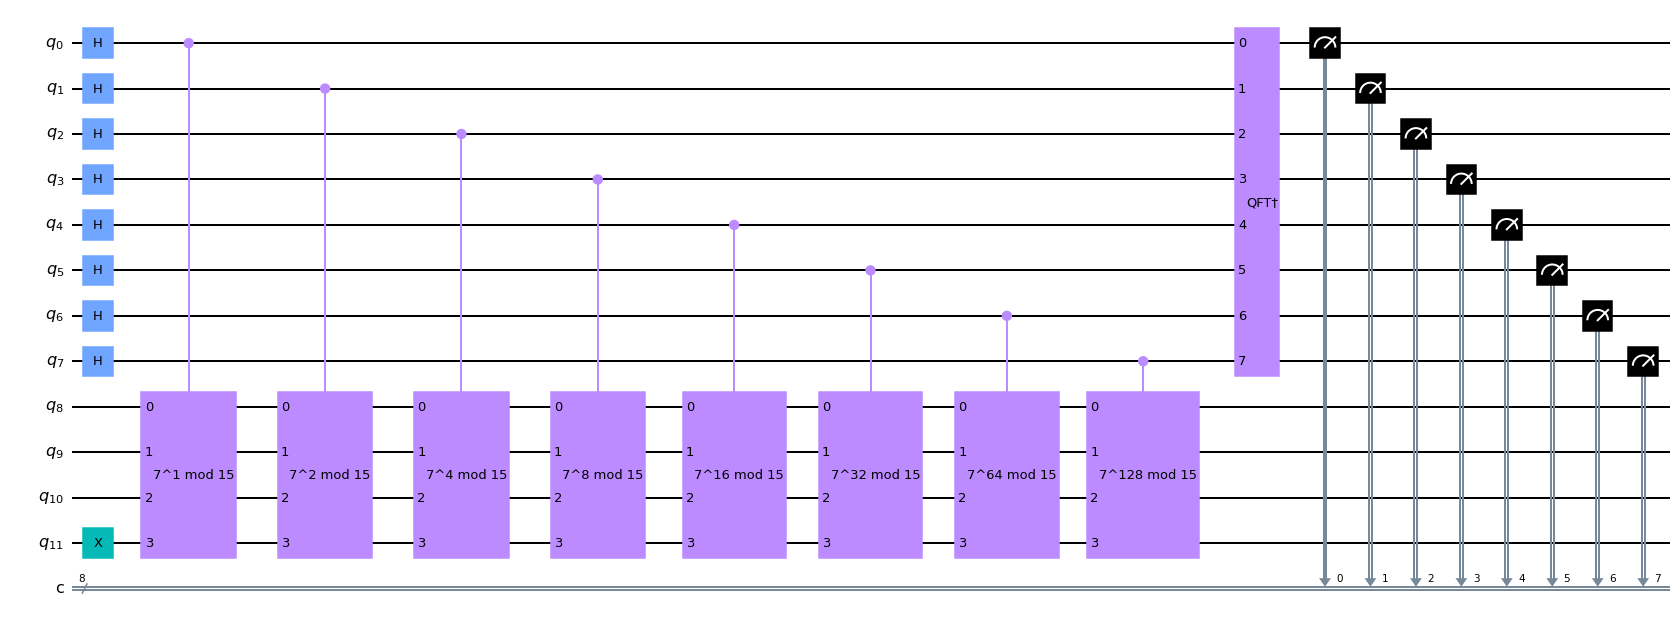

In [5]:
# Create QuantumCircuit with n_count counting qubits plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits in state |+>
for q in range(n_count):
    qc.h(q)
    
qc.x(3+n_count) # And auxiliary register in state |1>

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT

qc.measure(range(n_count), range(n_count)) # Measure circuit
qc.draw(fold=-1)  # -1 means 'do not fold' 

# Results

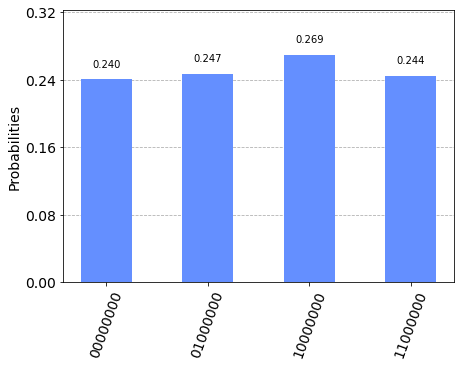

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)

results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

# Result's corresponding to measured phases

In [7]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{decimal}/{2**n_count} = {phase:.2f}"])

headers=["Register Output", "Phase"] # Print the rows in a table
df = pd.DataFrame(rows, columns=headers) # create data frame

print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


# Order r

In [8]:
rows = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])

headers=["Phase", "Fraction", "Guess for r"] # Print as a table
df = pd.DataFrame(rows, columns=headers) # create data frame

print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.75      3/4            4
2   0.00      0/1            1
3   0.50      1/2            2


We can see that two of the measured eigenvalues provided us with the correct result:  

r=4 and we can see that Shor’s algorithm has a chance of failing. 

These bad results are because  s=0 or because  s and r are not coprime and instead of r we are given a factor of r

# Shor's algorithm

a = 7

N = 15

phase to measure - s/r where a<sup>r</sup> mod N = 1, s is a random integer between 0 and r-1

In [9]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    
    qasm_sim = Aer.get_backend('qasm_simulator') # Simulate Results
    
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    
    print("Register Reading: " + readings[0])
    
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    
    return phase

In [10]:
# repeat until atleast one factor is found

a = 7
N = 15
factor_found = False
attempt = 0

while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator tells us r
    r = frac.denominator
    print("Result: r = %i" % r)
    
    if phase != 0:
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
